## **경희대학교 소프트웨어융합학과 23학번 김민서**

In [ ]:
# 필요한 패키지 임포트하기

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from folium import plugins
from IPython.display import display

### **충청남도 산사태 취약지역 현황**

In [ ]:
# 데이터 불러오기 및 확인하기

df_landslide=pd.read_csv("충청남도 산사태 취약지역 현황_20240101.csv", encoding='euc-kr')
df_landslide.head()

,대장ID,시군구,읍면동,리,지번,기타지번,위도(도),위도(분),위도(초),경도(도),경도(분),경도(초),취약지역유형,관리주체,지구,소유별,지정면적(제곱미터),거리(m),대피장소
0,78731,금산군,제원면,천내리,산6-33임_제2016-2호,해당없음,36,7,8.299,127,34,42.140,토석류,금산군,해당없음,사유림,500.0,3569.8,천내3리경로당
1,16987,금산군,제원면,저곡리,648구,해당없음,36,6,23.899,127,33,36.700,토석류,금산군,해당없음,사유림,480.0,200.0,저곡1리마을회관
2,24263,금산군,제원면,대산리,산33-1임,해당없음,36,7,57.199,127,33,18.800,토석류,금산군,해당없음,사유림,436.8,600.0,대산리경로당
3,102602,금산군,제원면,길곡리,산15임,해당없음,36,9,52.000,127,33,43.999,토석류,금산군,해당없음,사유림,850.0,450.0,길곡1리노인회관
4,20539,금산군,군북면,두두리,58전,해당없음,36,10,20.768,127,32,28.427,토석류,금산군,해당없음,사유림,1052.0,1200.0,군북면사무소


In [ ]:
# 데이터셋 수정하기

# 필요없는 칼럼 제거하기
df_landslide=df_landslide.drop(columns=['대장ID', '기타지번', '지구', '소유별'])

# 위경도 계산하기 (도, 분, 초로 표현되어있는 위경도 -> 소수점으로 표현된 위경도)
def dms_to_decimal(degrees, minutes, seconds):
  return degrees+minutes/60+seconds/3600

df_landslide['위도']=df_landslide.apply(lambda row: dms_to_decimal(row['위도(도)'], row['위도(분)'], row['위도(초)']), axis=1)
df_landslide['경도']=df_landslide.apply(lambda row: dms_to_decimal(row['경도(도)'], row['경도(분)'], row['경도(초)']), axis=1)

df_landslide=df_landslide.drop(columns=['위도(도)', '위도(분)', '위도(초)', '경도(도)', '경도(분)', '경도(초)'])
df_landslide=df_landslide[['위도', '경도', '취약지역유형', '관리주체', '거리(m)', '대피장소']]

df_landslide.head()

,위도,경도,취약지역유형,관리주체,거리(m),대피장소
0,36.118972,127.578372,토석류,금산군,3569.8,천내3리경로당
1,36.106639,127.560194,토석류,금산군,200.0,저곡1리마을회관
2,36.132555,127.555222,토석류,금산군,600.0,대산리경로당
3,36.164444,127.562222,토석류,금산군,450.0,길곡1리노인회관
4,36.172436,127.541230,토석류,금산군,1200.0,군북면사무소


In [ ]:
# 데이터 결측치 확인하기

df_landslide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   위도      1759 non-null   float64
 1   경도      1759 non-null   float64
 2   취약지역유형  1759 non-null   object 
 3   관리주체    1759 non-null   object 
 4   거리(m)   1759 non-null   float64
 5   대피장소    1759 non-null   object 
dtypes: float64(3), object(3)
memory usage: 82.6+ KB


### **걸음 수, 거리, 소요 시간 데이터**

In [ ]:
# 데이터 불러오기 및 확인

df_step=pd.read_csv("steps_data.csv")
df_step.head()

,Steps,km,time
0,5139.0,3.0,92
1,7416.0,4.0,113
2,4143.0,2.0,74
3,5055.0,3.0,93
4,6484.0,3.0,112


In [ ]:
# 데이터 결측치 확인하기

df_step.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Steps   94 non-null     float64
 1   km      94 non-null     float64
 2   time    94 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 KB


In [ ]:
# km -> m 로 단위 변경하기

# km 칼럼의 이름을 distance(m)로 변경하기
df_step.rename(columns={'km':'distance(m)'}, inplace=True)

# m 칼럼의 모든 데이터에 1000을 곱하기
df_step['distance(m)']=df_step['distance(m)']*1000

# 데이터 확인하기
df_step.head()

,Steps,distance(m),time
0,5139.0,3000.0,92
1,7416.0,4000.0,113
2,4143.0,2000.0,74
3,5055.0,3000.0,93
4,6484.0,3000.0,112


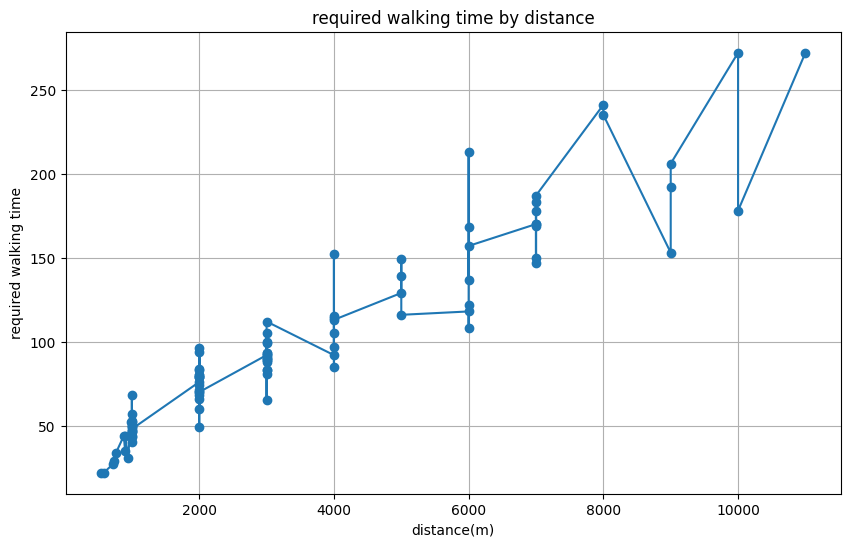

In [ ]:
# m 거리 값에 따라 소요 시간 그래프로 표현하기

df_step = df_step.sort_values(by='distance(m)')

plt.figure(figsize=(10, 6))
plt.plot(df_step['distance(m)'], df_step['time'], marker='o', linestyle='-')
plt.title('required walking time by distance')
plt.xlabel('distance(m)')
plt.ylabel('required walking time')
plt.grid(True)
plt.show()

In [ ]:
# distance(m) 칼럼이 갖는 데이터 확인하기

print(df_step['distance(m)'].unique())

[  540.   583.   716.   730.   766.   881.   899.   904.   942.   989.
  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000.]


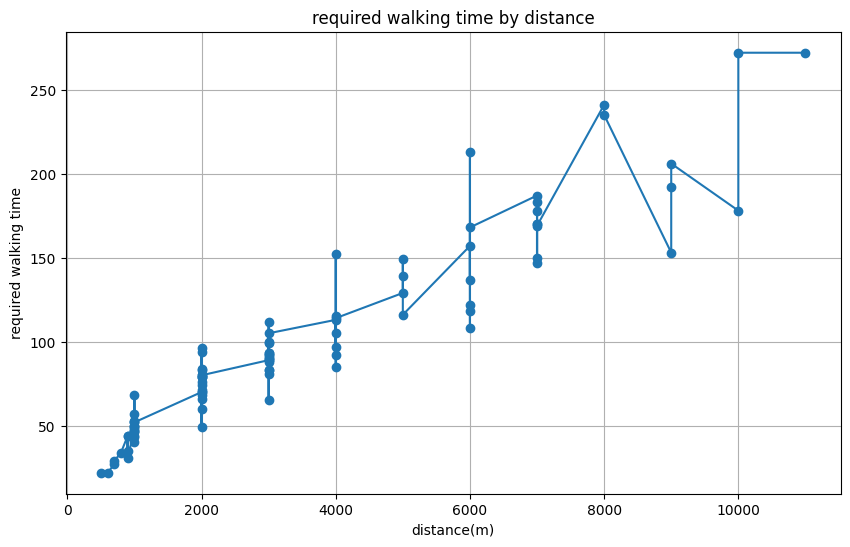

In [ ]:
# 거리 칼럼의 데이터를 100단위로 반올림하기

df_step['distance(m)']=np.round(df_step['distance(m)']/100)*100

# 다시 그래프 출력하기

df_step = df_step.sort_values(by='distance(m)')

plt.figure(figsize=(10, 6))
plt.plot(df_step['distance(m)'], df_step['time'], marker='o', linestyle='-')
plt.title('required walking time by distance')
plt.xlabel('distance(m)')
plt.ylabel('required walking time')
plt.grid(True)
plt.show()

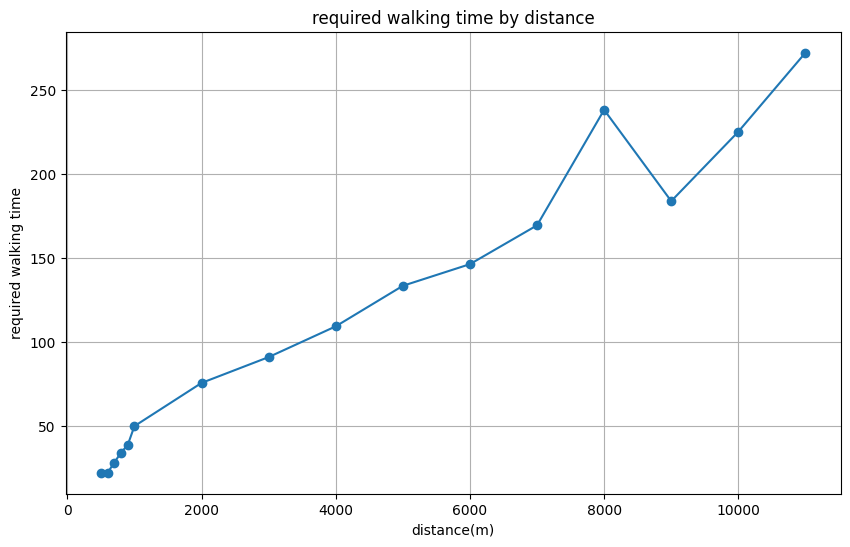

In [ ]:
# 거리별로 평균 내어 표현하기

df_step_mean=df_step.groupby('distance(m)').mean().reset_index()

# 다시 그래프 출력하기

df_step_mean = df_step_mean.sort_values(by='distance(m)')

plt.figure(figsize=(10, 6))
plt.plot(df_step_mean['distance(m)'], df_step_mean['time'], marker='o', linestyle='-')
plt.title('required walking time by distance')
plt.xlabel('distance(m)')
plt.ylabel('required walking time')
plt.grid(True)
plt.show()

In [ ]:
# distance의 값이 8000인 데이터 개수 확인하기
print(df_step[df_step['distance(m)'] == 8000].shape[0])

2


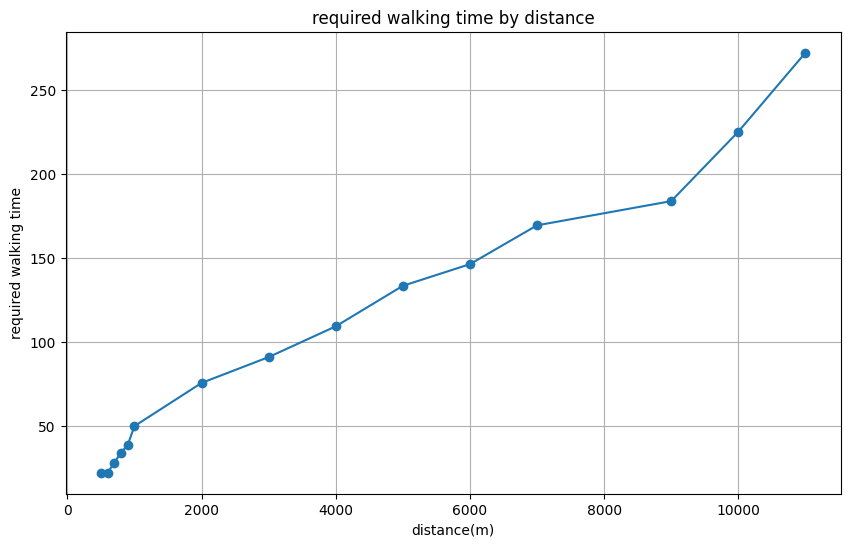

In [ ]:
# distance의 값이 8000인 데이터 삭제하기
df_step_mean=df_step_mean[df_step_mean['distance(m)']!=8000]

# 다시 그래프 출력하기

df_step_mean = df_step_mean.sort_values(by='distance(m)')

plt.figure(figsize=(10, 6))
plt.plot(df_step_mean['distance(m)'], df_step_mean['time'], marker='o', linestyle='-')
plt.title('required walking time by distance')
plt.xlabel('distance(m)')
plt.ylabel('required walking time')
plt.grid(True)
plt.show()

### **충청남도 산사태 취약지역 현황과 걸음 데이터 결합하기**

In [ ]:
# 충청남도 산사태 취약지역 현황과 걸음 데이터 결합하기

distance_values=df_step_mean['distance(m)'].values
time_values=df_step_mean['time'].values

df_landslide['걸음 소요시간']=df_landslide['거리(m)'].apply(lambda x:np.interp(x, distance_values, time_values))

# 데이터셋 확인하기
df_landslide.head()

,위도,경도,취약지역유형,관리주체,거리(m),대피장소,걸음 소요시간
0,36.118972,127.578372,토석류,금산군,3569.8,천내3리경로당,101.251707
1,36.106639,127.560194,토석류,금산군,200.0,저곡1리마을회관,22.000000
2,36.132555,127.555222,토석류,금산군,600.0,대산리경로당,22.000000
3,36.164444,127.562222,토석류,금산군,450.0,길곡1리노인회관,22.000000
4,36.172436,127.541230,토석류,금산군,1200.0,군북면사무소,54.875556


In [ ]:
# 걸음 소요시간이 100분이 넘어가는 데이터만 추출하기

df_far=df_landslide[df_landslide['걸음 소요시간']>100]
df_far=df_far.reset_index(drop=True)

print(len(df_far))
df_far.head()

26


,위도,경도,취약지역유형,관리주체,거리(m),대피장소,걸음 소요시간
0,36.118972,127.578372,토석류,금산군,3569.8,천내3리경로당,101.251707
1,36.253944,126.746917,토석류,부여군,4528.0,지티 보건진료소,121.863000
2,36.247472,126.760917,토석류,부여군,4903.0,천보1리마을회관,130.909875
3,36.063778,127.458389,토석류,금산군,3590.0,숲속마을작은학교,101.621397
4,36.196597,127.418700,토석류,금산군,4500.0,중두마을 경로당,121.187500


In [ ]:
# 가장 가까운 대피소까지 걸어가는 데 걸리는 시간이 100분이 넘어갈 정도로 먼 산사태 위험 지역을 지도에 표시

cnmap=folium.Map(location=[df_far['위도'].mean(), df_far['경도'].mean()], zoom_start=8)

for idx, row in df_far.iterrows():
  folium.CircleMarker(
      location=[row['위도'], row['경도']],
      radius=5,
      color='blue',
      fill=True,
      fill_color='blue',
      fill_opacity=0.6,
      popup=f"{row['대피장소']}, {row['걸음 소요시간']}",
  ).add_to(cnmap)

cnmap

### **대피 가능 시설들 찾기**

In [ ]:
# 1. 충청남도 노인복지시설

# 데이터 불러오기 및 확인

df_shelter1=pd.read_csv("충청남도_노인복지시설_20211231.csv", encoding='cp949')
df_shelter1.head()

,시군명,종류,시설명,주소,전화번호
0,천안시,양로시설,천안실버타운,충청남도 천안시 동남구 목천읍 운전4길 6,041-555-7773
1,천안시,양로시설,뉴천안실버타운,충청남도 천안시 동남구 목천읍 운전4길 20,041-557-7779
2,천안시,양로시설,평안의쉼터,충청남도 천안시 동남구 동면 충절로 2613,041-569-9016
3,천안시,노인공동생활가정,동산실버타운,충청남도 천안시 서북구 직산읍 남산4길 63,041-584-6363
4,천안시,노인공동생활가정,온유한집,충청남도 천안시 동남구 북면 대평1길 320,041-555-9726


In [ ]:
# 필요없는 칼럼들 삭제하기
df_shelter1=df_shelter1.drop(columns=['시군명', '전화번호'])

# 중복되는 데이터가 있는지 확인하고, 삭제하기
df_shelter1 = df_shelter1.drop_duplicates(subset='주소', keep='first')
df_shelter1.head()
print(len(df_shelter1))

623


In [ ]:
# 2. 충청남도 학교 시설

# 데이터 불러오기 및 확인

df_shelter2=pd.read_csv("충청남도교육청_충남학교현황_20230809.csv", encoding='cp949')
df_shelter2.head()

,연번,구분,행정구역,학교명,연면적,학급수,학생수(명),우편번호,주소,연락처,팩스번호
0,1,유치원,천안 성황동,천안초등학교병설유치원,90.00,1,14,31122,충남 천안시 동남구 중앙로 169,041-563-9807,041-568-0763
1,2,유치원,천안 오룡동,천안중앙초등학교병설유치원,700.00,1,5,31129,충남 천안시 동남구 영성로 73,041-552-3559,041-552-3564
2,3,유치원,천안 원성동,천안남산초등학교병설유치원,600.00,2,29,31132,충남 천안시 동남구 버들1길30,041-556-2910,041-551-8102
3,4,유치원,천안 백석동,환서초등학교병설유치원,135.00,1,5,31097,충남 천안시 서북구 한들2로 34-41,041-551-8380,041-553-4384
4,5,유치원,천안 부대동,천안부대초등학교병설유치원,101.25,1,16,31080,충남 천안시 서북구 공대길 37,041-551-2461,041-555-6059


In [ ]:
# 학교 시설의 경우, 약 150평인 연면적 500 이상만 남기고 삭제

df_shelter2=df_shelter2[df_shelter2['연면적'] >= 500]

In [ ]:
# 필요없는 칼럼들 삭제하기
df_shelter2=df_shelter2.drop(columns=['연번', '행정구역', '연면적', '학급수', '학생수(명)', '우편번호', '연락처', '팩스번호'])

# 칼럼명 수정하기 (df_shelter1과 통일)
df_shelter2.rename(columns={'구분':'종류', '학교명':'시설명'}, inplace=True)
df_shelter2 = df_shelter2.drop_duplicates(subset='주소', keep='first')

df_shelter2.head()
print(len(df_shelter2))

851


**대피 가능 시설들의 위경도를 계산하여 추가하기**

In [ ]:
address= df_shelter1['주소']
print(address.head())

0     충청남도 천안시 동남구 목천읍 운전4길 6
1    충청남도 천안시 동남구 목천읍 운전4길 20
2    충청남도 천안시 동남구 동면 충절로 2613
3    충청남도 천안시 서북구 직산읍 남산4길 63
4    충청남도 천안시 동남구 북면 대평1길 320
Name: 주소, dtype: object


In [ ]:
# 주소 데이터 깔끔하게 다듬기

for i in range(min(len(address), 25)):
  a = address[i].split(' ')
  address[i] = " ".join(a[0:4])

print(address)

0         충청남도 천안시 동남구 목천읍
1         충청남도 천안시 동남구 목천읍
2          충청남도 천안시 동남구 동면
3         충청남도 천안시 서북구 직산읍
4          충청남도 천안시 동남구 북면
              ...         
819      태안군 안면읍 안면대로 2669
820        태안군 태안읍 군청6길 24
822        태안군 태안읍 다락미1길 4
823    태안군 태안읍 백화로 121-122
826        태안군 이원면 발전로 939
Name: 주소, Length: 623, dtype: object


In [ ]:
# 맨 앞에 "충청남도"가 붙어있지 않은 경우 추가하기
def clean_address(addr):
    a = addr.split(' ')
    modified_address = " ".join(a[0:4])

    if not modified_address.startswith("충청남도"):
        modified_address = "충청남도 " + modified_address

    return modified_address

# 시리즈에 함수 적용
df_shelter1['주소'] = df_shelter1['주소'].apply(clean_address)

# 결과 확인
print(df_shelter1['주소'])

0              충청남도 천안시 동남구 목천읍
1              충청남도 천안시 동남구 목천읍
2               충청남도 천안시 동남구 동면
3              충청남도 천안시 서북구 직산읍
4               충청남도 천안시 동남구 북면
                 ...           
819      충청남도 태안군 안면읍 안면대로 2669
820        충청남도 태안군 태안읍 군청6길 24
822        충청남도 태안군 태안읍 다락미1길 4
823    충청남도 태안군 태안읍 백화로 121-122
826        충청남도 태안군 이원면 발전로 939
Name: 주소, Length: 623, dtype: object


In [ ]:
# 도로명주소 위도 경도 값으로 바꿔주기

geo_local = Nominatim(user_agent='South Korea')

# 위도, 경도 반환하는 함수
def geocoding(address):
    try:
      geo = geo_local.geocode(address)
      x_y = [geo.latitude, geo.longitude]
      return x_y

    except:
      return [0,0]

In [ ]:
# 주소를 위,경도 값으로 변환하기

latitude = []
longitude =[]

for i in address:
  latitude.append(geocoding(i)[0])
  longitude.append(geocoding(i)[1])

In [ ]:
# Dataframe 만들기

df_shelter3=pd.DataFrame({'종류': df_shelter1['종류'],'시설명':df_shelter1['시설명'],'주소':address,'위도':latitude,'경도':longitude})

df_shelter3.head()

,종류,시설명,주소,위도,경도
0,양로시설,천안실버타운,충청남도 천안시 동남구 목천읍,36.785012,127.234674
1,양로시설,뉴천안실버타운,충청남도 천안시 동남구 목천읍,36.785012,127.234674
2,양로시설,평안의쉼터,충청남도 천안시 동남구 동면,36.776200,127.344334
3,노인공동생활가정,동산실버타운,충청남도 천안시 서북구 직산읍,36.878102,127.148966
4,노인공동생활가정,온유한집,충청남도 천안시 동남구 북면,36.827480,127.273280


In [ ]:
address= df_shelter2['주소']
print(address.head())

1         충남 천안시 동남구 영성로 73
2         충남 천안시 동남구 버들1길30
6       충남 천안시 동남구 청수로 35-3
12       충남 천안시 서북구 미라2길 13
17    충남 천안시 서북구 성성6로 47-11
Name: 주소, dtype: object


In [ ]:
# 주소 데이터 깔끔하게 다듬기
for i in range(min(len(address), 25)):
  a = address.iloc[i].split(' ')
  address.iloc[i] = " ".join(a[0:4])

print(address)

1                          충남 천안시 동남구 영성로
2                       충남 천안시 동남구 버들1길30
6                          충남 천안시 동남구 청수로
12                        충남 천안시 서북구 미라2길
17                        충남 천안시 서북구 성성6로
                      ...                
1241                    충남 천안시 서북구 월봉로 48
1242                  충남 보령시 주교면 보령북로 404
1243                   충남 아산시 염치읍 현충사길 93
1244                충남 아산시 둔포면 아산밸리동로 247
1245    충남 천안시 동남구 충절로 535-31(고려신학대학원 내) 
Name: 주소, Length: 851, dtype: object


In [ ]:
def replace_chungnam(addr):
  if addr.startswith('충남'):
    return '충청남도'+addr[2:]
  return addr

df_shelter2['주소']=df_shelter2['주소'].apply(replace_chungnam)

print(df_shelter2['주소'].head())

1        충청남도 천안시 동남구 영성로
2     충청남도 천안시 동남구 버들1길30
6        충청남도 천안시 동남구 청수로
12      충청남도 천안시 서북구 미라2길
17      충청남도 천안시 서북구 성성6로
Name: 주소, dtype: object


In [ ]:
# 도로명주소 위도 경도 값으로 바꿔주기
geo_local = Nominatim(user_agent='South Korea')

# 위도, 경도 반환하는 함수
def geocoding(address):
    try:
      geo = geo_local.geocode(address)
      x_y = [geo.latitude, geo.longitude]
      return x_y

    except:
      return [0,0]

In [ ]:
# 주소를 위,경도 값으로 변환하기
latitude = []
longitude =[]

for i in address:
  latitude.append(geocoding(i)[0])
  longitude.append(geocoding(i)[1])

In [ ]:
# Dataframe 만들기
df_shelter4 = pd.DataFrame({'종류': df_shelter2['종류'],'시설명':df_shelter2['시설명'],'주소':address,'위도':latitude,'경도':longitude})

df_shelter4.head()

,종류,시설명,주소,위도,경도
1,유치원,천안중앙초등학교병설유치원,충남 천안시 동남구 영성로,36.798457,127.147979
2,유치원,천안남산초등학교병설유치원,충남 천안시 동남구 버들1길30,0.000000,0.000000
6,유치원,천안청수초등학교병설유치원,충남 천안시 동남구 청수로,36.788206,127.152275
12,유치원,천안미라초등학교병설유치원,충남 천안시 서북구 미라2길,36.800644,127.130734
17,유치원,천안가람초등학교병설유치원,충남 천안시 서북구 성성6로,36.841562,127.123666


In [ ]:
# df_shelter3과 df_shelter4 합치기
df_shelter=pd.concat([df_shelter3, df_shelter4], ignore_index=True)

In [ ]:
# 위도와 경도 칼럼에서 0의 값을 갖는 행 삭제
df_shelter=df_shelter[(df_shelter['위도']!=0)&(df_shelter['경도']!=0)]

df_shelter.head()
print(len(df_shelter))

851


In [ ]:
# 가장 가까운 대피소 추출 및 산사태 위험 지역과 가장 가까운 대피소 사이의 거리 계산
def find_closest_shelter(lat, lon, shelters_df):
  distances=shelters_df.apply(lambda row: geodesic((lat, lon), (row['위도'], row['경도'])).meters, axis=1)
  closet_index=distances.idxmin()
  return shelters_df.loc[closet_index]

df_far['추천 대피소']=np.nan
df_far['추천 대피소 위도']=np.nan
df_far['추천 대피소 경도']=np.nan

for i in range(len(df_far)):
  closest_shelter = find_closest_shelter(df_far.at[i, '위도'], df_far.at[i, '경도'], df_shelter)
  df_far.at[i, '추천 대피소'] = closest_shelter['시설명']
  df_far.at[i, '추천 대피소 위도'] = closest_shelter['위도']
  df_far.at[i, '추천 대피소 경도'] = closest_shelter['경도']

# 위도 경도 칼럼 이름을 산사태 위도, 산사태 경도로 변경하기
df_far = df_far.rename(columns={'위도': '산사태 위도', '경도': '산사태 경도'})
df_far.head()

<ipython-input-37-b7ad3a14b171>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '제원초등학교' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_far.at[i, '추천 대피소'] = closest_shelter['시설명']


,산사태 위도,산사태 경도,취약지역유형,관리주체,거리(m),대피장소,걸음 소요시간,추천 대피소,추천 대피소 위도,추천 대피소 경도
0,36.118972,127.578372,토석류,금산군,3569.8,천내3리경로당,101.251707,제원초등학교,36.112858,127.546455
1,36.253944,126.746917,토석류,부여군,4528.0,지티 보건진료소,121.863000,내산초등학교,36.268711,126.785815
2,36.247472,126.760917,토석류,부여군,4903.0,천보1리마을회관,130.909875,내산초등학교,36.268711,126.785815
3,36.063778,127.458389,토석류,금산군,3590.0,숲속마을작은학교,101.621397,남이초등학교,36.073892,127.447293
4,36.196597,127.418700,토석류,금산군,4500.0,중두마을 경로당,121.187500,복수중학교,36.209910,127.378487


In [ ]:
# 산사태 위험 지역과 추천 대피소 위치를 지도에 표현하기
m = folium.Map(location=[df_far['산사태 위도'].mean(), df_far['산사태 경도'].mean()], zoom_start=10)

for i in range(len(df_far)):
  # 산사태 위치 (빨간 점)
  folium.Marker(
      location=[df_far.at[i, '산사태 위도'], df_far.at[i, '산사태 경도']],
      popup=f"산사태 위치 {i+1}",
      icon=folium.Icon(color='red')
    ).add_to(m)

  # 대피소 위치 (파란 점)
  folium.Marker(
      location=[df_far.at[i, '추천 대피소 위도'], df_far.at[i, '추천 대피소 경도']],
      popup=df_far.at[i, '추천 대피소'],
      icon=folium.Icon(color='blue')
    ).add_to(m)

  # 산사태 위치와 대피소 위치를 선으로 연결 (빨간색)
  folium.PolyLine(
      locations=[
          [df_far.at[i, '산사태 위도'], df_far.at[i, '산사태 경도']],
          [df_far.at[i, '추천 대피소 위도'], df_far.at[i, '추천 대피소 경도']]
      ],
      color='red'
    ).add_to(m)

display(m)